# Fine-Tuning BERT for Phishing URL Detection with Hugging-Face 🤗 

This notebook demonstrates the fine-tuning of a BERT model for phishing URL detection, using a [dataset](https://huggingface.co/datasets/zakariajaadi/phishing-url-classification) I published on Hugging Face specifically curated for this task. The dataset comprises URLs labeled as negative (0, Safe) or positive (1, Phishing), enabling us to leverage BERT's pre-trained knowledge to effectively classify malicious URLs. We will then evaluate the model's performance in accurately distinguishing between phishing and legitimate urls

# 1- Load Dataset 

In [50]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import torch
import evaluate
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

**Get dataset from Hugging Face hub**

In [3]:
dataset_dict = load_dataset("zakariajaadi/phishing-url-classification")

**Plot Class Distirbution**

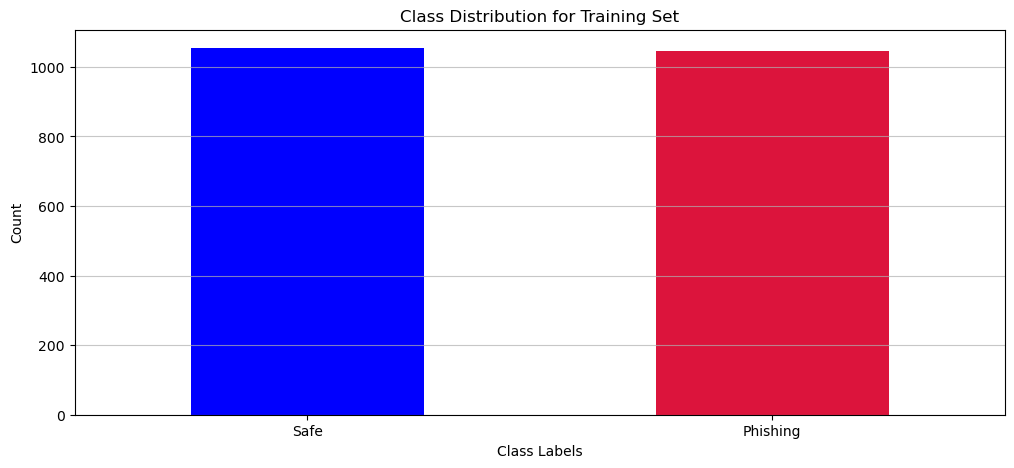

In [5]:
# Convert the train dataset to a pandas DataFrame
train_df = pd.DataFrame(dataset_dict["train"])

# Count the occurrences of each class label
label_counts = train_df['labels'].value_counts()

# Plot the class distribution
plt.figure(figsize=(12, 5))
label_counts.plot(kind='bar', color=['blue', 'crimson'])
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution for Training Set")
plt.xticks(ticks=[0, 1], labels=["Safe", "Phishing"], rotation=0)
plt.grid(axis="y", alpha=0.7)


plt.show()

The dataset is almost prefectly balanced ! ... but wait, the bar chart looks suspiciously like the French flag haha. it seems to be feeling very *Vive la République* 🍷🥐


# 2- Load BERT's model and tokenizer

In [6]:
#BERT Model 
model_checkpoint = "google-bert/bert-base-uncased"

**Load tokenizer and tokenize dataset**

In [7]:
# Load bert tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [8]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Apply tokenization to the dataset
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

**Load model with binary classification head** (110M params, 4 Bytes each, model size 440 MB)

In [9]:
id2label = {0: "Safe", 1: "Phishing"}
label2id = {"Safe": 0, "Phishing": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                           num_labels=2, 
                                                           id2label=id2label, 
                                                           label2id=label2id,)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Freeze base model (BERT) parameters**

In [10]:
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

**Define compute_metrics function to use for training**

In [28]:
# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
roc_auc_metric = evaluate.load("roc_auc")

# Define compute_metrics function
def compute_metrics(eval_preds):
   
    logits, labels = eval_preds

    # --- Calculate ROC AUC --- 
    
    # Apply Softmax to get probabilities
    probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    # Select probs of the postive class 
    positive_class_probs = probabilities[:, 1]

    # AUC
    roc_auc_score= roc_auc_metric.compute(prediction_scores=positive_class_probs, references=labels)['roc_auc']
    roc_auc_score = np.round(roc_auc_score, 3)
    
    # --- Calculate accuracy --- 
   
    # Get predictions classes
    predicted_classes = np.argmax(logits, axis=1)
   
    # accuracy
    accuracy_score = accuracy_metric.compute(predictions=predicted_classes, references=labels)['accuracy']
    accuracy_score = np.round(accuracy_score, 3)
    
    return {"Accuracy": accuracy_score, "AUC": roc_auc_score}


# 3- Fine Tune the Model

In [12]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
# hyperparameters
lr = 2e-4
batch_size = 8
num_epochs = 10

training_args = TrainingArguments(
    output_dir="bert-phishing-classifier_teacher",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [14]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.497000,0.371518,0.818000,0.917000
2,0.402600,0.319748,0.862000,0.940000
3,0.368400,0.327306,0.851000,0.943000
4,0.371600,0.307220,0.876000,0.945000
5,0.350600,0.295006,0.876000,0.947000
6,0.361100,0.288449,0.884000,0.950000
7,0.341700,0.285410,0.878000,0.951000
8,0.352300,0.297764,0.876000,0.951000
9,0.349900,0.300407,0.880000,0.951000
10,0.311000,0.289589,0.876000,0.952000


TrainOutput(global_step=2630, training_loss=0.3706201154469537, metrics={'train_runtime': 2118.0042, 'train_samples_per_second': 9.915, 'train_steps_per_second': 1.242, 'total_flos': 689344798377840.0, 'train_loss': 0.3706201154469537, 'epoch': 10.0})

**Plot Loss train vs validation**

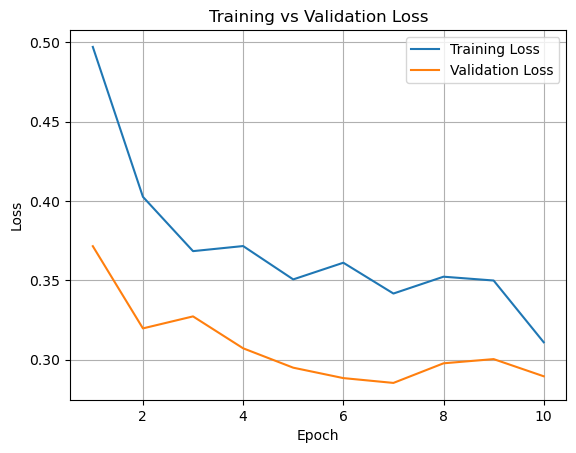

In [15]:
import matplotlib.pyplot as plt

# Extract logs from trainer
logs = trainer.state.log_history

# Initialize lists to store losses and epochs
train_losses = []
val_losses = []
epochs = []

# Iterate through logs and extract training and validation losses
for log in logs:
    if 'loss' in log:  # Training loss
        train_losses.append(log['loss'])
        epochs.append(log['epoch'])
    if 'eval_loss' in log:  # Validation loss
        val_losses.append(log['eval_loss'])

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

> #### <span style="color:green"> **Good learning overall !** </span> The model trains well and generalizes effectively, showing a consistent decrease  in both training and validation loss despite some fluctuations

# 4 - Evaluate model on the test data

**predict test data**

In [ ]:
# Make predictions for test dataset
predictions = trainer.predict(tokenized_datasets["test"])

# Extract the logits and labels from the predictions
logits = predictions.predictions
labels = predictions.label_ids

# Get Predicted Classes
predicted_classes=np.argmax(logits, axis=1)

# Apply Softmax to get probabilities
probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()
positive_class_probs = probabilities[:, 1]

**Evaluate**

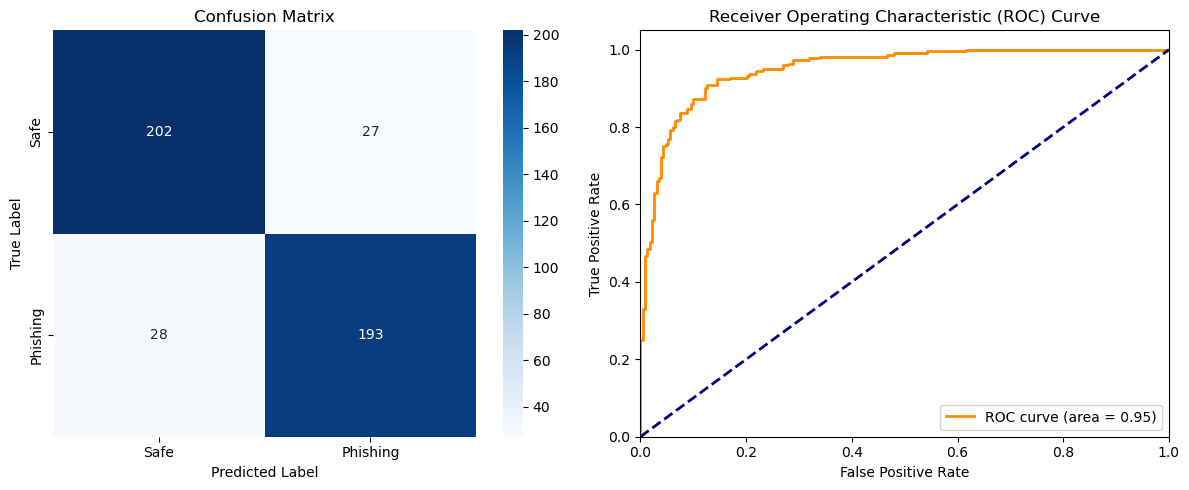

Accuracy: 87.78%, ROC-AUC: 0.95


In [49]:
# Confusion Matrix
cm = confusion_matrix(labels, predicted_classes)

accuracy=accuracy_score(labels,predicted_classes)

# ROC-AUC Plot
fpr, tpr, thresholds = roc_curve(labels, positive_class_probs)
roc_auc = auc(fpr, tpr)

# Create the figure
plt.figure(figsize=(12, 5))

# Plot Confusion Matrix
plt.subplot(1, 2, 1)  
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Safe', 'Phishing'], yticklabels=['Safe', 'Phishing'])
plt.title(f"Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot ROC-AUC Curve
plt.subplot(1, 2, 2)  
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy * 100:.2f}%, ROC-AUC: {roc_auc:.2f}")

> #### <span style="color:green">**Strong performance 🎉** </span> **The fine-tuned model shows a good accuracy and a strong descriminative power** 

# Conclusion

> The **BERT-based** phishing URL detection model, fine-tuned on just 2,100 URLs, achieved 88% accuracy and an AUC of 0.95, demonstrating impressive performance for a relatively small dataset. This suggests that BERT is highly effective in identifying phishing URLs, and the model's performance could further improve with more training data.